In [28]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit
import scipy.signal

In [73]:
#path = r"C:/Data/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/" 
path =  'C:/Data/20230321/step8/' #'C:/Data/20230317/TEST/'
SRS_gain = 5 # gain on the SRS bandpass filter
peak_threshold = 700 # upper bound of pedestal
breakdown = 27.4 # breakdown voltage of the SiPM
pedestal = 275 # center of noise pedestal peak

file_list = natsort.realsorted(glob.glob(path + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list))

Found 6 files


In [38]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [39]:
def rebin_histogram(bins, counts, new_bin_size):
    """Rebin a histogram to a new bin size.
    Parameters:
        bins (np.ndarray): The bin edges of the histogram.
        counts (np.ndarray): The number of counts in each bin.
        new_bin_size (float): The size of the new bins.
    Returns:
        np.ndarray: The new bin edges.
        np.ndarray: The new bin counts.
    """
    # Find the new number of bins
    new_nbins = int((bins[-1] - bins[0]) / new_bin_size)
    # Create the new bin edges
    new_bins = np.linspace(bins[0], bins[-1], new_nbins + 1)
    # Digitize the original bins into the new bins
    digitized_bins = np.digitize(bins, new_bins)
    # Calculate the new counts
    new_counts = np.array([counts[digitized_bins == i].sum() for i in range(1, new_nbins + 1)])

    new_centers = new_bins[:-1] + np.diff(new_bins)/2
    return new_centers, new_counts

In [40]:
def find_peaks_and_fit(x, y, max_peaks=5, min_thresh =100):
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    peaks_index, _ = scipy.signal.find_peaks(y, threshold=5, distance=500)

    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    peak_params = []
    peak_number =1 # corresponds to single photoelectron
    for peak in peaks_index[:max_peaks]:
        if peak < min_thresh:
            continue

        # Initial guess for the Gaussian parameters
        amplitude_guess = y[peak]
        mean_guess = x[peak]
        standard_deviation_guess = 1 
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]

        # Perform the curve fitting
        try:
            params, params_covariance = curve_fit(gauss_fun, x, y, p0=initial_guess)
        except RuntimeError as r:
            peak_params.append([peak, np.nan, np.nan, np.nan])
            xx = np.linspace( x[peak] - 4*standard_deviation_guess, x[peak] + 4*standard_deviation_guess, 100 )
            plt.plot( xx, gauss_fun(xx, *initial_guess), 'b' )
            continue
        peak_params.append([peak_number, params[1], np.sqrt(params_covariance[1,1])])
        peak_number+=1 # (goes to n*spe until it reaches max_peak)

    # Plot the original spectrum and the fitted Gaussian peaks
    #plt.plot(x, y, 'o', label='Original spectrum')
    for params in peak_params:
        plt.plot(x, gauss_fun(x, *params), label='Fitted peak')
    #plt.legend()
    plt.show()
    return np.array(peak_params)

In [74]:
guess_1pe = 1100 * SRS_gain/100 - pedestal ## based on highest gain data
guess_sig = 0.1


gain_vs_volts = []
for i,file in enumerate(file_list): 
    print("Working on file #%d: %s"%(i,file))

    file_parts = file.split("_")
    print(file_parts)
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    file_wavelength = float(file_parts[-2]) # get wavelength from filename



    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b,c = rebin_histogram(bin_num, mca_hist, 75)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    #plt.semilogy(bin_num, mca_hist, 'k')
    plt.semilogy(b, c, 'k')
    #plt.ylim(0.1, np.max(mca_hist)*2)
    plt.ylim(0.1, 5000)
    plt.xlim(0.1, 16000)

    if( len(gain_vs_volts)> 0):
        guess_1pe = gain_vs_volts[-1][1] * (file_volts-breakdown)/(gain_vs_volts[-1][0]-breakdown) 

    pe_locs = find_peaks_and_fit(bin_num, mca_hist)
    plt.xlim(0, guess_1pe*6)


    plt.subplot(1,2,2)
    plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

    fpts = ~np.isnan(pe_locs[:,1])
    if(np.sum(fpts) < 3):
        continue
    gain_bp, gain_bc = curve_fit( lin_fun, pe_locs[fpts, 0], pe_locs[fpts, 1] )

    xx = pe_locs[fpts, 0]
    plt.plot( xx, lin_fun(xx, *gain_bp), 'r')

    gain_vs_volts.append( [file_volts, gain_bp[0], np.sqrt(gain_bc[0,0]), file_wavelength] )

    plt.show()

Working on file #0: C:/Data/20230321/step8\mca_keith_31.40OV_source_1.h5
['C:/Data/20230321/step8\\mca', 'keith', '31.40OV', 'source', '1.h5']


ValueError: could not convert string to float: 'source'

In [37]:
print(gain_vs_volts) ## 2nd array - last value looks WAY off
gain_vs_volts = np.array(gain_vs_volts)
wl_to_use = gain_vs_volts[:,3] == 405
print(wl_to_use)
print(np.array(gain_vs_volts[wl_to_use,:]))

[[3.39000000e+01 1.08269690e+03 8.03433551e-01 4.05000000e+02]
 [3.39000000e+01 1.64588426e+03 1.32235435e+02 3.10000000e+02]
 [3.34000000e+01 9.97793548e+02 1.01936512e+00 4.05000000e+02]
 [3.34000000e+01 1.00266730e+03 1.64932971e+00 3.10000000e+02]
 [3.29000000e+01 9.18356859e+02 1.00429047e+00 4.05000000e+02]
 [3.29000000e+01 9.20980549e+02 4.82314947e-01 3.10000000e+02]
 [3.24000000e+01 8.37651259e+02 1.05704199e+00 4.05000000e+02]
 [3.24000000e+01 8.38537068e+02 7.75278567e-01 3.10000000e+02]
 [3.19000000e+01 7.52579270e+02 7.85326053e-01 4.05000000e+02]
 [3.19000000e+01 7.53774059e+02 1.28934622e+00 3.10000000e+02]
 [3.14000000e+01 6.71429751e+02 7.33652525e-01 4.05000000e+02]
 [3.14000000e+01 6.71022493e+02 6.98268414e-01 3.10000000e+02]
 [3.09000000e+01 5.85341939e+02 1.15092447e+00 4.05000000e+02]
 [3.09000000e+01 5.87301855e+02 6.62724267e-01 3.10000000e+02]
 [3.04000000e+01 5.14406433e+02 7.46166363e+00 4.05000000e+02]
 [3.04000000e+01 5.02966324e+02 3.02081921e-01 3.100000

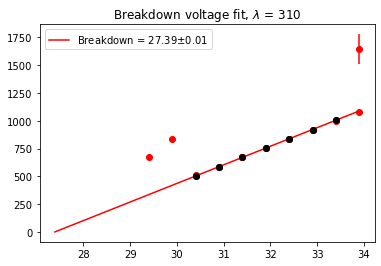

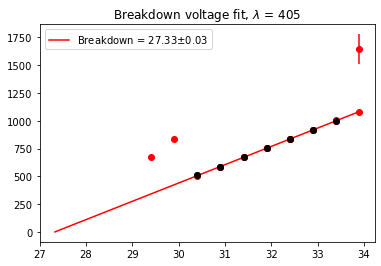

In [49]:
# change to have linear fit for both leds -- will need to use file_parts[-2][:-2] to separate them out -- will need to loop in block above

gain_vs_volts = np.array(gain_vs_volts[::-1])
wavelength = [310, 405]

voltages_to_exclude = [29.4, 29.9, 33.9]

for wl in wavelength:

    rows_to_skip = []
    for v in gain_vs_volts[:,0]:
        if(v in voltages_to_exclude):
            rows_to_skip.append(False)
        else:   
            rows_to_skip.append(True)
    rows_to_skip = np.array(rows_to_skip)
    
    rows_to_use = gain_vs_volts[:,3] == wl #select rows with the desired wavelength
    rows_to_use = rows_to_use & rows_to_skip
    bd_bp, bd_bc = curve_fit(lin_fun, gain_vs_volts[rows_to_use, 0], gain_vs_volts[rows_to_use, 1], sigma=gain_vs_volts[rows_to_use, 2])

    plt.figure()
    plt.errorbar(gain_vs_volts[:,0], gain_vs_volts[:,1], yerr=gain_vs_volts[:,2], fmt='ro')
    plt.errorbar(gain_vs_volts[rows_to_use,0], gain_vs_volts[rows_to_use,1], yerr=gain_vs_volts[rows_to_use,2], fmt='ko')
    #plt.errorbar(gain_vs_volts[~rows_to_use,0], gain_vs_volts[~rows_to_use,1], yerr=gain_vs_volts[~rows_to_use,2], fmt='ro')
    xx = np.linspace(bd_bp[1], np.max(gain_vs_volts[:,0]), 100)
    plt.plot(xx, lin_fun(xx,*bd_bp), 'r', label="Breakdown = %.2f$\pm$%.2f"%(bd_bp[1], np.sqrt(bd_bc[1,1])))
    plt.title("Breakdown voltage fit, $\lambda$ = %d"%wl)
    plt.legend()
    plt.show()

In [45]:
print(rows_to_use)

[False False False  True False  True False  True False  True False  True
 False  True False  True False False]


Found 20 files
Working on file #0: C:/Data/20230321/Step9\mca_keith_31.40OV_source_19.h5
Found 20 files
Working on file #0: C:/Data/20230321/Step9\mca_keith_31.40OV_310_19.h5
Found 20 files
Working on file #0: C:/Data/20230321/Step9\mca_keith_31.40OV_405_19.h5


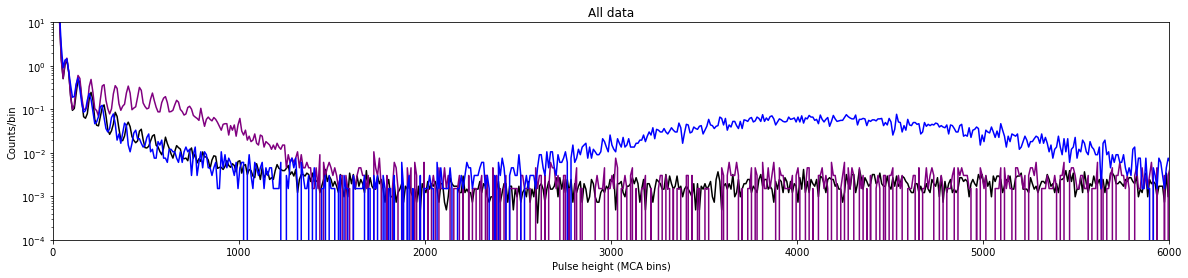

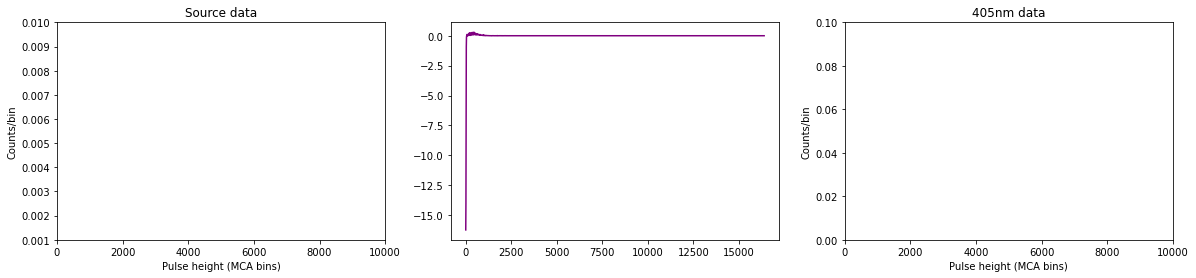

In [112]:
## Plot latest file

path = r"C:/Data/20230321/Step9/"

type_list = ['source', '310', '405']
col_list = ['k', 'purple','b']
nfiles = 1
norm_range = [3000, 12000] ## set range to normalize counts (leave empty to not use)

ref_hist = 0
fig1 = plt.figure(figsize=(20,4))
#fig2 = plt.figure(figsize=(20,4))
fig2, axl = plt.subplots(1,3, figsize=(20,4))
for j,t in enumerate(type_list):
    file_list = natsort.realsorted(glob.glob(path + "*mca*%s*.h5"%t))
    print("Found %d files"%len(file_list))


    for i,file in enumerate(file_list[-nfiles:]): 
        print("Working on file #%d: %s"%(i,file))

        #file_parts = file.split("_")
        #file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))

        b, c = rebin_histogram(bin_num, mca_hist, 10)

        if(len(norm_range)==2):
            if(not t == "405"): 
                gpts = (b < norm_range[1]) & (b > norm_range[0])
                norm_fac = np.sum(c[gpts])
        else:
            norm_fac = 1

        if(t == "source"):
            ref_hist = c/norm_fac
        plt.figure(fig1.number)
        plt.semilogy(b, c/norm_fac, color=col_list[j])

        if(t == "310"):
            axl[j].plot(b, c/norm_fac - ref_hist, color=col_list[j])

        if(t == "405"):
            axl[j].plot(b, c/norm_fac - ref_hist, color=col_list[j])

        if(t == "source"):
            axl[j].semilogy(b, c/norm_fac, color=col_list[j])

plt.figure(fig1.number)
plt.xlabel('Pulse height (MCA bins)')
plt.ylabel('Counts/bin')
plt.title('All data')
plt.ylim(1e-4,1e1)
plt.xlim(0,6000)

plt.figure(fig2.number)
ax = axl[1]
ax.set_xlabel('Pulse height (MCA bins)')
ax.set_ylabel('Counts/bin')
ax.set_title('310nm data')
ax.set_ylim(0,0.5)
ax.set_xlim(0,2000)

plt.subplot(1,3,3)
ax = axl[2]
ax.set_xlabel('Pulse height (MCA bins)')
ax.set_ylabel('Counts/bin')
ax.set_title('405nm data')
ax.set_ylim(0,0.1)
ax.set_xlim(0,10000)

plt.subplot(1,3,1)
ax = axl[0]
ax.set_xlabel('Pulse height (MCA bins)')
ax.set_ylabel('Counts/bin')
ax.set_title('405nm data')
ax.set_ylim(1e-3,1e-2)
ax.set_xlim(0,10000)

plt.show()